# **CNN for Image Classification**


In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **MNIST Dataset**

**Load dataset**

In [3]:
ROOT = './data'

train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
    )

In [4]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
train_data.targets.shape

torch.Size([60000])

In [9]:
test_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [10]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [11]:
# plot images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')

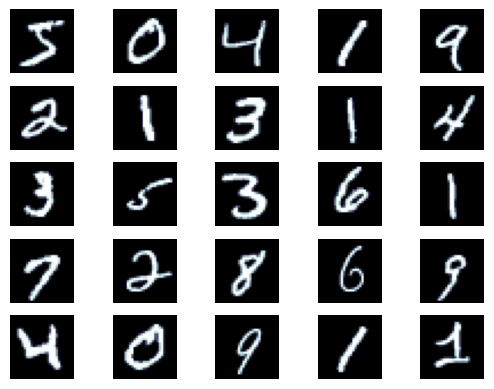

In [12]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

**Preprocessing**

Train:Valid = 0.9:0.1

In [13]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [14]:
train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

In [15]:
len(train_data)

54000

In [16]:
len(valid_data)

6000

**Preprocessing with `transforms`**

- Normalization (mean, sdt)
- Convert to tensor

In [17]:
# compute mean and std
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255
mean, std

(tensor(0.1307), tensor(0.3081))

In [18]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [19]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

**DataLoader**

In [20]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

In [21]:
len(train_dataloader)

211

In [22]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

In [23]:
inputs, labels = next(iter(train_dataloader))

**Model**

In [24]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [25]:
num_classes = len(train_data.dataset.classes)
num_classes

10

In [26]:
lenet_model = LeNetClassifier(num_classes)

In [27]:
lenet_model

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
predictions = lenet_model(inputs)

In [29]:
predictions.shape

torch.Size([256, 10])

**Loss & Optimizer**

In [30]:
optimizer = optim.Adam(lenet_model.parameters())

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
loss = criterion(predictions, labels)
loss

tensor(2.3053, grad_fn=<NllLossBackward0>)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

**Trainer**

In [35]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [36]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  211 batches | accuracy    0.694
| epoch   0 |   100/  211 batches | accuracy    0.890
| epoch   0 |   150/  211 batches | accuracy    0.916
| epoch   0 |   200/  211 batches | accuracy    0.942


In [37]:
train_acc, train_loss

(0.9441823899371069, 0.48507565602448316)

In [38]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [39]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [40]:
eval_acc, eval_loss

(0.9441666666666667, 0.19237332387516895)

**Training**

In [43]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.652
| epoch   1 |   100/  211 batches | accuracy    0.889
| epoch   1 |   150/  211 batches | accuracy    0.915
| epoch   1 |   200/  211 batches | accuracy    0.932
-----------------------------------------------------------
| End of epoch   1 | Time: 15.48s | Train Accuracy    0.939 | Train Loss    0.511 | Valid Accuracy    0.944 | Valid Loss    0.190 
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.950
| epoch   2 |   100/  211 batches | accuracy    0.954
| epoch   2 |   150/  211 batches | accuracy    0.957
| epoch   2 |   200/  211 batches | accuracy    0.965
-----------------------------------------------------------
| End of epoch   2 | Time: 20.21s | Train Accuracy    0.965 | Train Loss    0.143 | Valid Accuracy    0.966 | Valid Loss    0.117 
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.969
| epoch   3 

In [44]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
eval_acc, eval_loss

(0.9808333333333333, 0.06342926078165571)

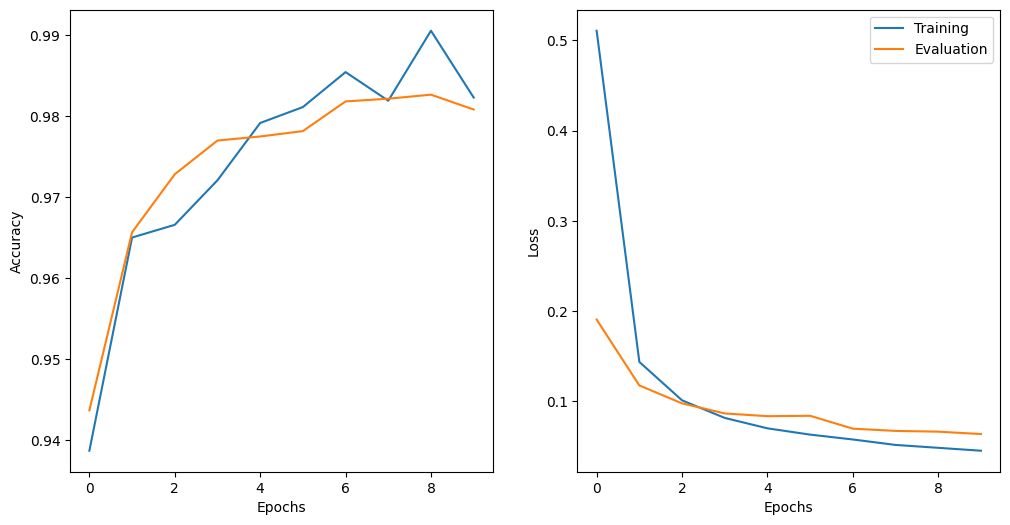

In [45]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

**Evaluation & Prediction**

In [46]:
test_data.transform = test_transforms

In [47]:
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [48]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.9839, 0.0460924735183653)

In [49]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

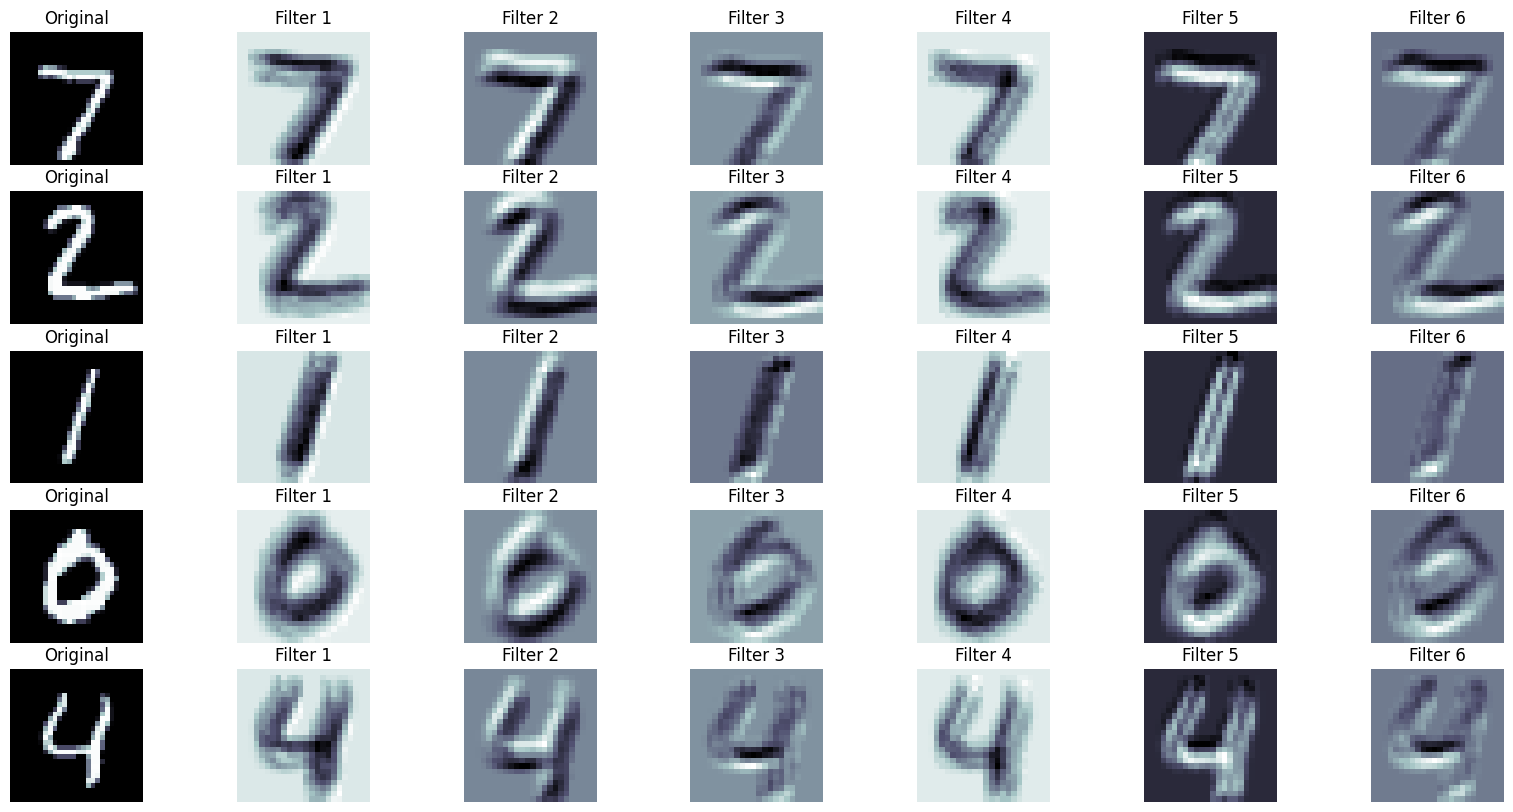

In [50]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = lenet_model.conv1.weight.data

plot_filtered_images(images, filters)

**Inference**

In [51]:
def load_model(model_path, num_classes=10):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    w, h = image.size
    if w != h:
        crop = transforms.CenterCrop(min(w, h))
        image = crop(image)
        wnew, hnew = image.size
    img_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])
    ])
    img_new = img_transform(image)
    img_new = img_new.expand(1, 1, 28, 28)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [52]:
model = load_model('/content/model/lenet_model.pt')
preds = inference('/content/demo_8.png', model)
preds

(0.9999868869781494, 8)

## **Cassava Leaf Disease**

**Load dataset**

Dowload dataset

In [53]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip

--2024-12-11 07:26:40--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘/content/cassavaleafdata.zip’

/content/cassavalea 100%[===================>]   1.26G  23.1MB/s    in 59s     

2024-12-11 07:27:39 (22.1 MB/s) - ‘/content/cassavaleafdata.zip’ saved [1354096203/1354096203]



In [54]:
!unzip /content/cassavaleafdata.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

**Read dataset**

In [55]:
%cd /content/cassavaleafdata

/content/cassavaleafdata


In [56]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

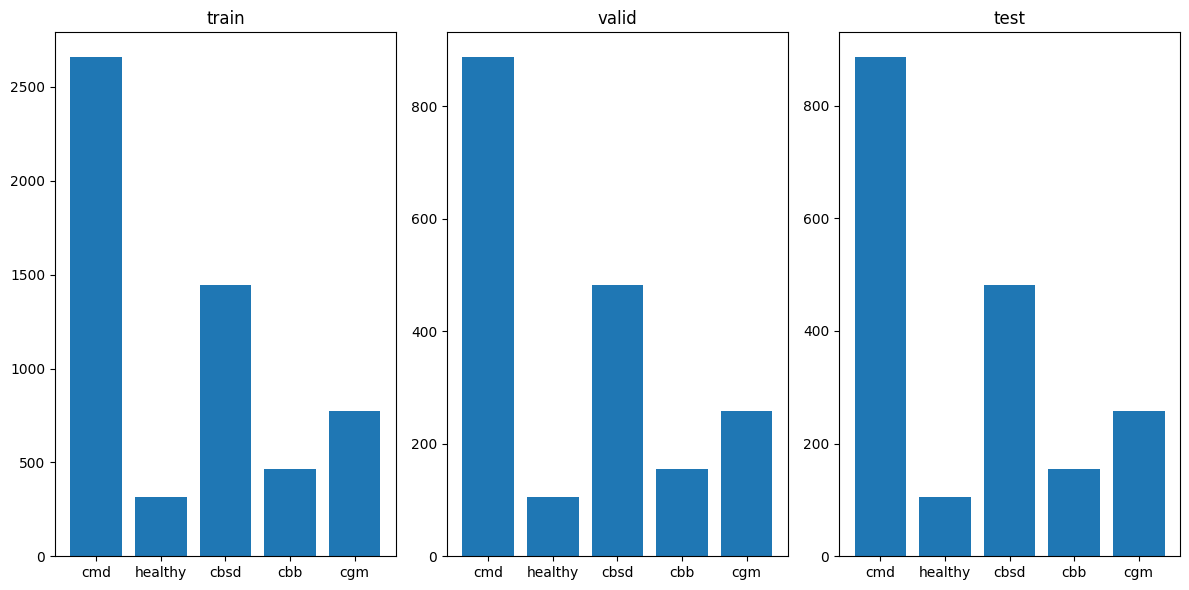

In [57]:
from imutils import paths
def show_labels(data_paths):
    fig, ax = plt.subplots(1, len(data_paths), figsize=(12,6))
    for idx, (key, sub_dir) in enumerate(data_paths.items()):
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(key)
    plt.tight_layout()
    plt.show()

show_labels(data_paths)

In [58]:
labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

In [59]:
def plot_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = Image.open(image_dir)
        label = image_dir.split('/')[-2]
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(labels_dict[label])
        ax[i//(num_sample//2)][i%(num_sample//2)].axis('off')
    plt.tight_layout()
    plt.show()

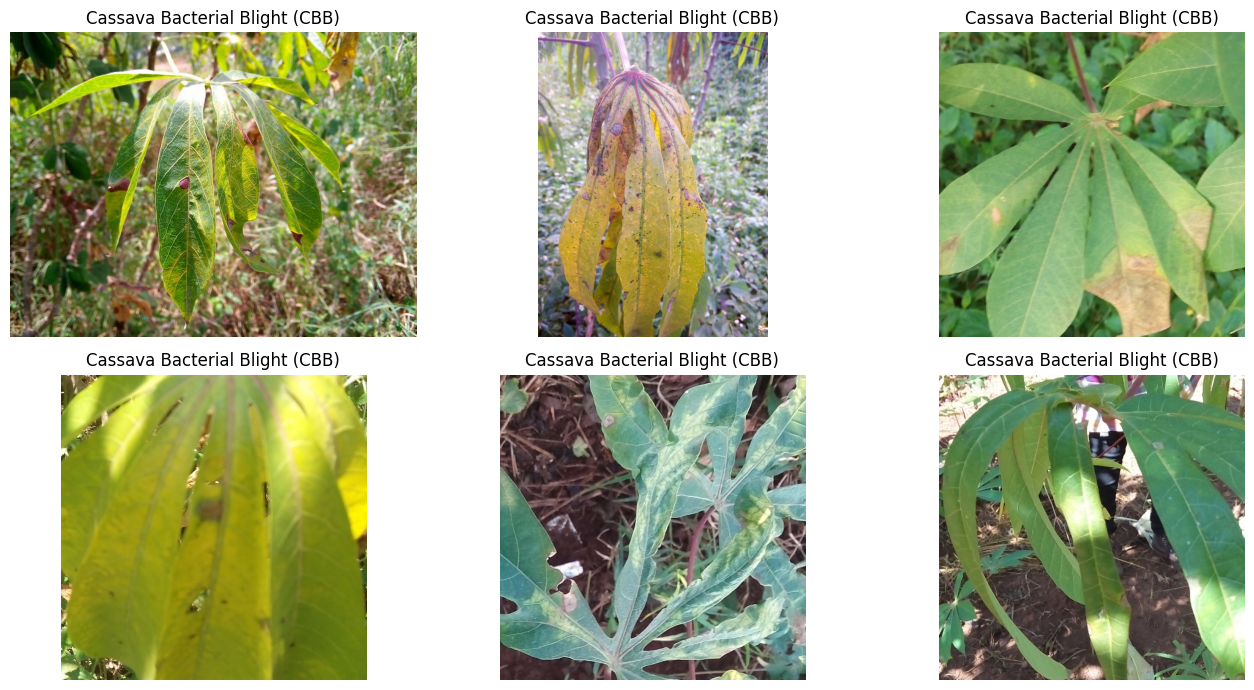

In [60]:
plot_images(data_paths['train'], label="cbb")

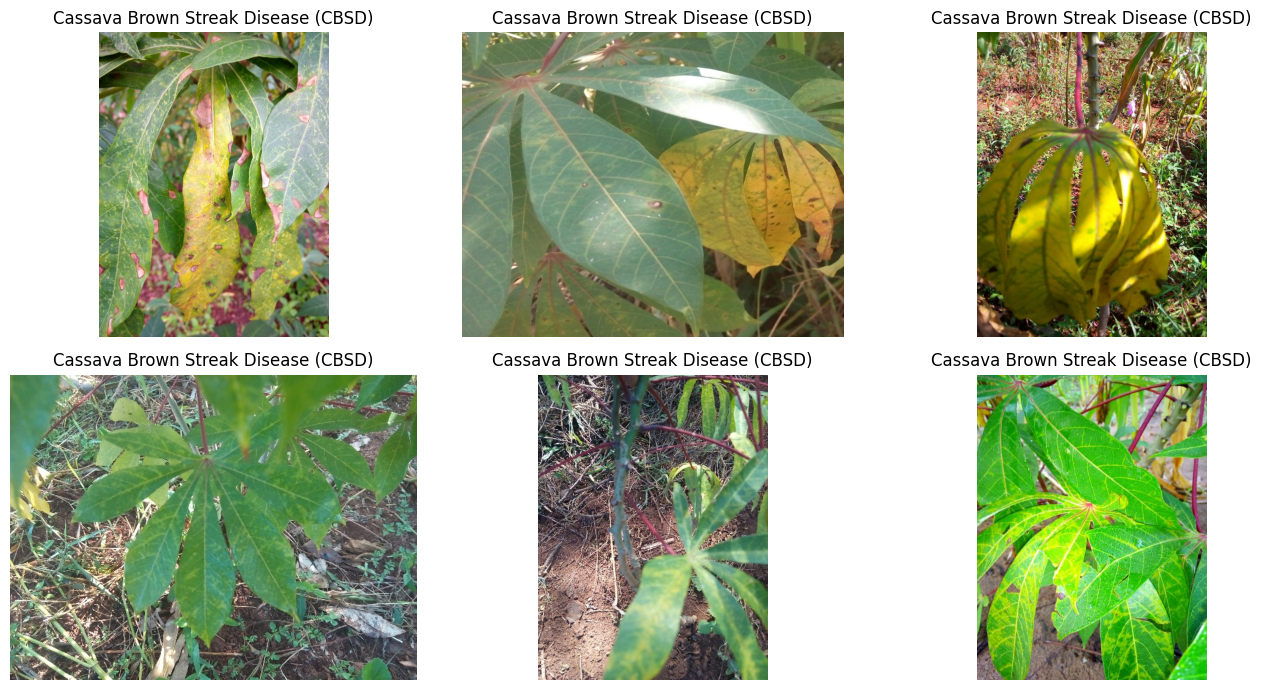

In [61]:
plot_images(data_paths['train'], label="cbsd")

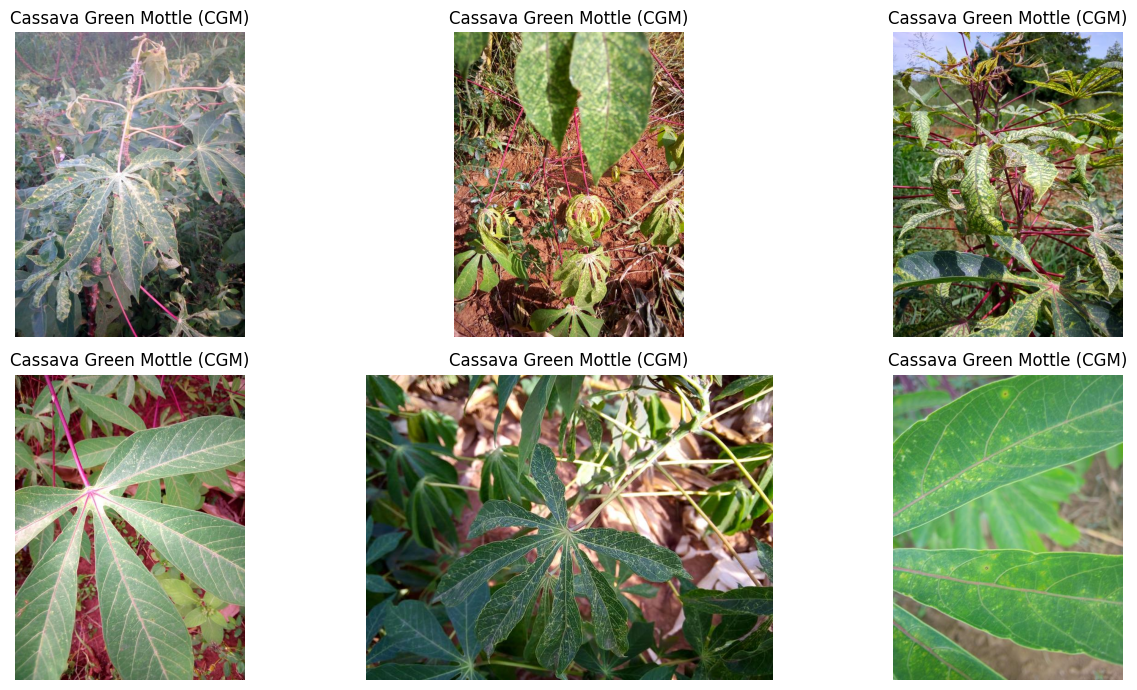

In [62]:
plot_images(data_paths['train'], label="cgm")

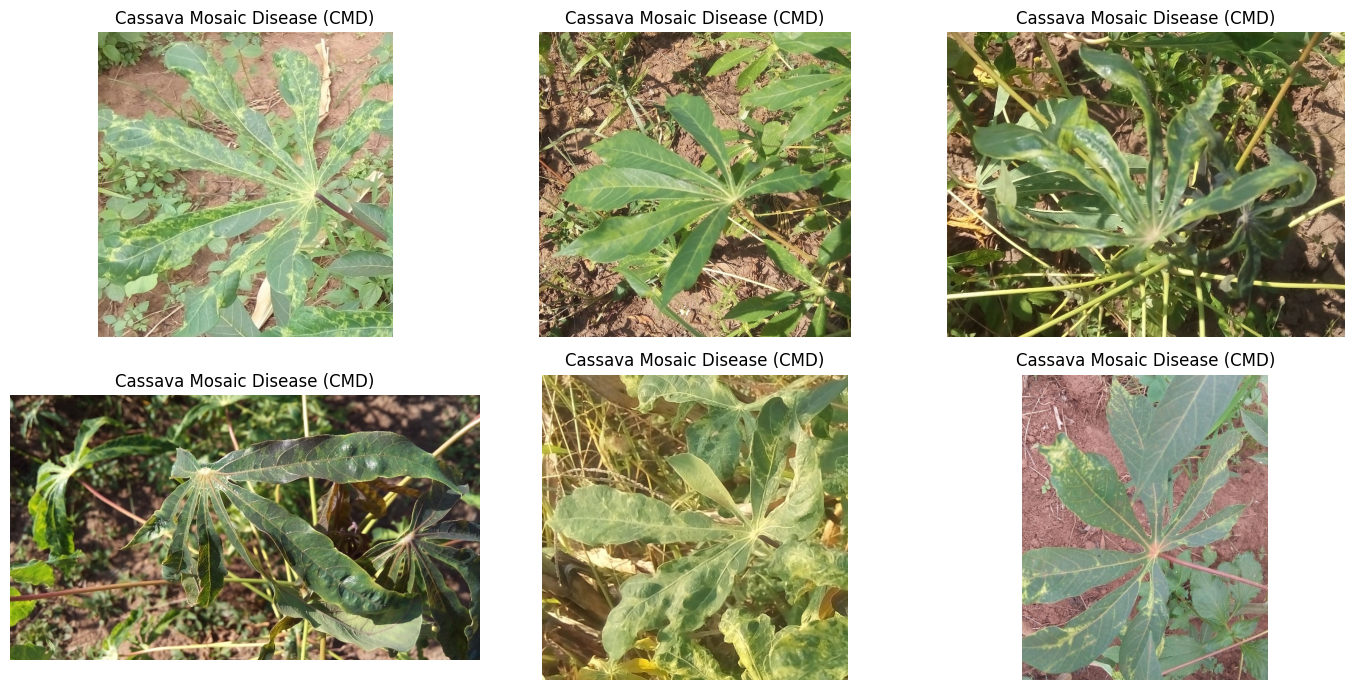

In [63]:
plot_images(data_paths['train'], label="cmd")

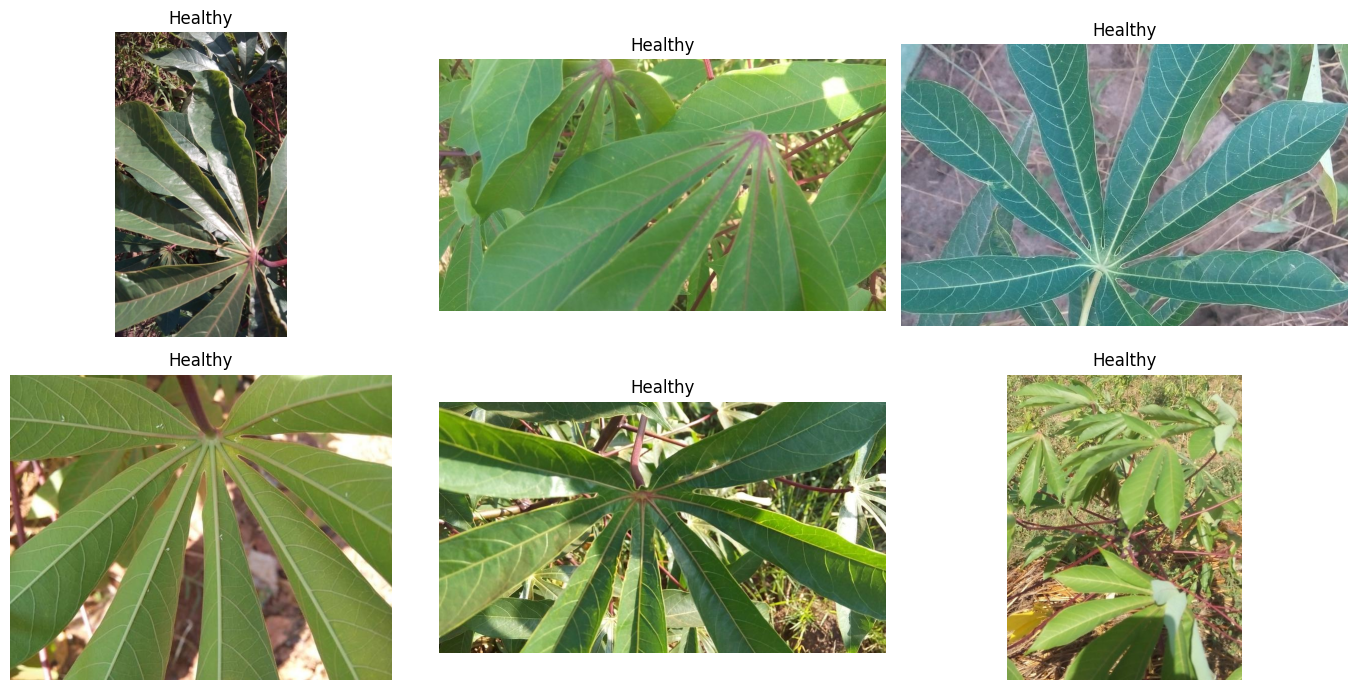

In [64]:
plot_images(data_paths['train'], label="healthy")

**Preprocessing**

In [65]:
# load image from path
def loader(path):
    return Image.open(path)

In [66]:
img_size = 150

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [67]:
train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

**DataLoader**

In [68]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [69]:
len(train_dataloader)

12

In [70]:
inputs, labels = next(iter(train_dataloader))

**Model**

In [71]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [72]:
num_classes = len(train_data.classes)
num_classes

5

In [73]:
lenet_model = LeNetClassifier(num_classes)

In [86]:
summary(lenet_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.20
Params size (MB): 9.02
Estimated Total Size (MB): 11.48
----------------------------------------------------------------


In [75]:
inputs.shape

torch.Size([512, 3, 150, 150])

In [76]:
predictions = lenet_model(inputs)

In [77]:
predictions

tensor([[-0.0437, -0.0409, -0.0207, -0.0299, -0.0370],
        [-0.0409, -0.0426, -0.0197, -0.0354, -0.0379],
        [-0.0392, -0.0424, -0.0202, -0.0316, -0.0393],
        ...,
        [-0.0457, -0.0379, -0.0241, -0.0298, -0.0363],
        [-0.0468, -0.0430, -0.0205, -0.0328, -0.0348],
        [-0.0439, -0.0395, -0.0194, -0.0322, -0.0387]],
       grad_fn=<AddmmBackward0>)

**Loss & Optimizer**

In [78]:
optimizer = optim.Adam(lenet_model.parameters())

In [79]:
criterion = nn.CrossEntropyLoss()

In [80]:
loss = criterion(predictions, labels)
loss

tensor(1.6086, grad_fn=<NllLossBackward0>)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

**Trainer**

In [83]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [87]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

In [88]:
train_acc, train_loss

(0.44324611032531824, 1.3793857097625732)

In [89]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [90]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [91]:
eval_acc, eval_loss

(0.4695606140815246, 1.3662903308868408)

**Training**

In [102]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy    0.444


RuntimeError: Parent directory ./model does not exist.

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

**Evaluation & Prediction**

In [ ]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

**Inference**

In [ ]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [ ]:
model = load_model('./model/lenet_model.pt')
preds = inference('/content/cassavaleafdata/test/cbsd/test-cbsd-1.jpg', model)
preds

In [ ]:
train_data.class_to_idx

In [ ]:
idx2label = {
  0: 'cbb',
  1: 'cbsd',
  2: 'cgm',
  3: 'cmd',
  4: 'healthy',
}

In [ ]:
idx2label[4]

# **CNN for Text Classification**

**Load dataset**

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git

In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [ ]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [ ]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

**Preprocessing**

In [ ]:
!pip install langid

In [ ]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [ ]:
train_df_vi, train_df_other = identify_vn(train_df)

In [ ]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [ ]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

In [ ]:
train_df_vi

**Representation**

In [ ]:
!pip install torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
vocabulary["<pad>"]

In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

**DataLoader**

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_dataloader))

In [ ]:
encoded_sentences, labels = next(iter(train_dataloader))

In [ ]:
encoded_sentences.shape

**Model**

In [ ]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [ ]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [ ]:
vocab_size

In [ ]:
predictions = model(encoded_sentences)
predictions

In [ ]:
predictions.shape

**Loss & Optimizer**

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loss = criterion(predictions, labels)
loss

**Trainer**

In [ ]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
model.to(device)

In [ ]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

In [ ]:
epoch_acc, epoch_loss

In [ ]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [ ]:
eval_acc, eval_loss

**Training**

In [ ]:
import torch.nn.functional as F

In [ ]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        print('Save model at ./model/text_cnn_model.pt')
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

**Evaluation & Prediction**

In [ ]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
test_acc, test_loss

**Inference**

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    sentence = preprocess_text(sentence)
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [ ]:
torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

In [ ]:
model = load_model('./model/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][5999], vocabulary, model)

In [ ]:
test_df

In [ ]:
inference('Đồ ăn rất ngon và rẻ', vocabulary, model)

In [ ]:
test_df['preprocess_sentence'][5999]